# DRKG Entity Embedding Similarity Analysis
This nodebook shows how to analyze the trained entity embeddings

In this example, we first load the trained entity embeddings and map them back into original entity names. And then apply two methodologies to analyze these embeddings:
 - Project all the entity embeddings into low dimension space and visualize their distribution.
 - Use cosine distance to analyze the similarity between each entity.

In [1]:
import pandas as pd
import numpy as np
import os
import csv

## Loading Entity ID Mapping

In [2]:
entity2id = {}
id2entity = {}
with open("./train/entities.tsv", newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['entity','id'])
    for row_val in reader:
        id = row_val['id']
        entity = row_val['entity']

        entity2id[entity] = int(id)
        id2entity[int(id)] = entity

print("Number of entities: {}".format(len(entity2id)))

Number of entities: 97055


## Loading Entity Embeddings

In [3]:
entity_emb = np.load('./ckpts/TransE_l2_DRKG_0/DRKG_TransE_l2_entity.npy')
print(entity_emb.shape)

(97055, 400)


## General Entity Embedding Clustering
Here we use t-SNE to convert entity embeddings into low dimension space and visualize their distribution.

In [4]:
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
from MulticoreTSNE import MulticoreTSNE as TSNE

X_embedded = TSNE(n_components=2, n_jobs=40).fit_transform(entity_emb).T

#plt.savefig('entityation.png')

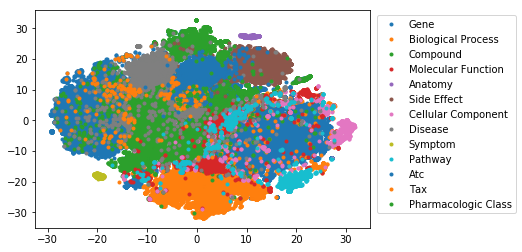

In [5]:
dataset_id = {}
for entity_name, i in entity2id.items():
    entity_key = entity_name.split('::')[0]
    if dataset_id.get(entity_key, None) is None:
        dataset_id[entity_key] = []
    dataset_id[entity_key].append(i)

p = cm.rainbow(int(255/2 * 1))
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=np.long)

    plt.plot(X_embedded[0][val], X_embedded[1][val], '.', label=key)
    plt.legend(bbox_to_anchor=(0, 0, 1.45, 1.0))

plt.show()

## Calculate entity cosine similarity

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(entity_emb)

Plot entity cosine similarity distribution

In [7]:
similarity=similarity.flatten()
print(similarity.shape)

# cleanup self-compare and dup-compare
s = similarity < 0.99
s = np.unique(similarity[s])

(9419673025,)


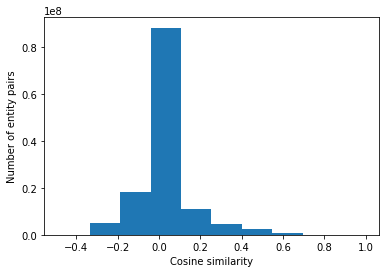

In [8]:
import matplotlib.pyplot as plt
plt.xlabel('Cosine similarity')
plt.ylabel('Number of entity pairs')
plt.hist(s)
plt.show()

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(entity_emb)
idx = np.flip(np.argsort(similarity), axis=1)

max_pairs = []
for i in range(idx.shape[0]):
    j = 1
    while (similarity[i][idx[i][j]] > 0.9):
        max_pairs.append((id2entity[idx[i][0]], id2entity[idx[i][j]], similarity[i][idx[i][j]]))
        j += 1

def sort_score(pair):
    return pair[2]

max_pairs.sort(reverse=True, key=sort_score)
sim_pairs = []
for i, pair in enumerate(max_pairs):
    if i % 2 == 0:
        sim_pairs.append(pair)

sim_pairs[:10]

[('Molecular Function::GO:0005528',
  'Molecular Function::GO:0005527',
  0.9988377),
 ('Molecular Function::GO:0019198',
  'Molecular Function::GO:0005001',
  0.99838895),
 ('Biological Process::GO:0055090',
  'Biological Process::GO:0070328',
  0.9982072),
 ('Cellular Component::GO:0001931',
  'Cellular Component::GO:0031254',
  0.99762934),
 ('Molecular Function::GO:0016817',
  'Molecular Function::GO:0016818',
  0.99736154),
 ('Atc::R02', 'Atc::R02A', 0.9973049),
 ('Molecular Function::GO:0016462',
  'Molecular Function::GO:0016818',
  0.99729884),
 ('Molecular Function::GO:0016817',
  'Molecular Function::GO:0016462',
  0.99727356),
 ('Cellular Component::GO:0099512',
  'Cellular Component::GO:0099513',
  0.99671894),
 ('Biological Process::GO:0003376',
  'Biological Process::GO:0090520',
  0.9965954)]